In [1]:
import numpy as np
import bokeh 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="ticks", color_codes = True)
%matplotlib inline

## Setting up geographic bounding boxes.

There are cleaner ways to do this, such as a DataFrame for the bounding boxes, geopandas or even lists. This was a quick and dirty way to establish the variables and enable the flagging function.

In [2]:
##Establishing Bounding Box Values - there are cleaner ways to do this boundingboxDF, geopandas, etc..
bot_US = 24.396308
left_US = -124.848974
top_US = 49.384358
right_US = -66.885444

bot_HI = 18.910361
left_HI = -178.334698
top_HI = 28.402123
right_HI= -154.806773

bot_AK = 51.214183
left_AK = -179.148909
top_AK = 71.365162
right_AK = 179.77847

## Ingestion

A quick function to:

- Read in CSV to DataFrame
- Clean up some column dtypes
- Extract Day/Month/Year into columns
- Prepare DataFrame for filtering

In [7]:
def import_data():
    file_encoding = 'utf-8'
    injuries_file = './data/severeinjury_withcounties.csv'
    pd.set_option('display.max_columns',None)
    injury_data = pd.read_csv(injuries_file, encoding = 'cp850', dtype = 'unicode')
    injury_data['EventDate'] = injury_data['EventDate'].astype('datetime64')
    injury_data['Month'] = pd.DatetimeIndex(injury_data['EventDate']).month
    injury_data['Day'] = pd.DatetimeIndex(injury_data['EventDate']).day
    injury_data['Year'] = pd.DatetimeIndex(injury_data['EventDate']).year
    injury_data.Latitude = injury_data.Latitude.astype("float")
    injury_data.Longitude = injury_data.Longitude.astype("float")
    return injury_data

## Determining Location

In initial geospatial EDA, determined that a small percentage of reported injuries were overseas in countries such as Finland, Tanzania, etc. Created a function to check each row of the df and see if it falls within the bounding boxes for the lower 48, Hawaii and Alaska. Then assigns an integer value of either 0 (international) or 1 (within 50 United States).

In [8]:
def isitin(maybe):
    for row in maybe:
        if (bot_US <= maybe.Latitude) & (maybe.Latitude <= top_US) & (left_US <= maybe.Longitude) & (maybe.Longitude <= right_US):
            return 1
        elif (bot_HI <= maybe.Latitude) & (maybe.Latitude <= top_HI) & (left_HI <= maybe.Longitude) & (maybe.Longitude <= right_HI):
            return 1
        elif (bot_AK <= maybe.Latitude) & (maybe.Latitude <= top_AK) & (left_AK <= maybe.Longitude) & (maybe.Longitude <= right_AK):
            return 1
        else:
            return 0  

## Execute ingest, initial wrangle and export out to CSV

In [9]:
def main():
    data = import_data()
    df = pd.DataFrame(data)
    df['InsideUS'] = df.apply(isitin, axis=1)
    df.to_csv('./data/wrangled_injury.csv', encoding = 'utf-8')
    return df

In [10]:
if __name__ == "__main__":
    df = main()

In [11]:
df.head()

,field_1,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,Longitude,Primary NA,Hospitaliz,Amputation,Inspection,Final Narr,Nature,NatureTitl,Part of Bo,Part of _1,Event,EventTitle,Source,SourceTitl,Secondary,Secondar_1,GEOID,NAME,NAMELSAD,Month,Day,Year,InsideUS
0,4904,2015074249,997441,2015-07-01,Sapp Bros. Inc.,660 S. Main St.,NaN,WEST POINT,NEBRASKA,68788,41.83,-96.71,454310,2,0,1074916,A leaking propane tank exploded within the sho...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,323,"Explosion of pressure vessel, piping, or tire",2125,Propane tanks and cylinders,NaN,NaN,31039,Cuming,Cuming County,7,1,2015,1
1,24574,2017065473,1228909,2017-06-15,Unified Pet Products LLC,126 W. Grant St,NaN,WEST POINT,NEBRASKA,68788,41.83,-96.71,311119,0,1,1241496,An employee was emptying a ribbon mixer and at...,1311,Amputations,4429,"Finger(s), fingernail(s), n.e.c.",6412,Caught in running equipment or machinery durin...,3714,"Mixers, blenders, whippers-food and beverage",NaN,NaN,31039,Cuming,Cuming County,6,15,2017,1
2,24861,2017065806,1238273,2017-06-24,"West Point Dairy Products, LLC",1715 E Road,NaN,WEST POINT,NEBRASKA,68788,41.79,-96.70,311512,0,1,1245502,"On June 24, 2017, at 10:50 a.m. an employee wa...",1311,Amputations,4422,Fingertip(s),6411,Caught in running equipment or machinery durin...,3421,Conveyors-belt,NaN,NaN,31039,Cuming,Cuming County,6,24,2017,1
3,38473,2018099614,1384150,2018-09-17,"West Point Dairy Products, LLC",1715 E Road,NaN,WEST POINT,NEBRASKA,68788,41.79,-96.70,311512,1,0,NaN,An employee was hospitalized for heat stress a...,1729,"Effects of heat and light, n.e.c.",6,BODY SYSTEMS,531,Exposure to environmental heat,9262,Heat-environmental,NaN,NaN,31039,Cuming,Cuming County,9,17,2018,1
4,109,2015010146,930752,2015-01-06,ASTRO BUILDINGS INC.,17400 N. 84th Street,NaN,LINCOLN,NEBRASKA,68517,40.98,-96.60,236220,1,0,NaN,"On January 6, 2015, a worker sustained a fract...",111,Fractures,52,Ankle(s),40,"Fall, slip, trip, unspecified",660,"Floors, walkways, ground surfaces, unspecified",9273,"Ice, sleet, snow",31109,Lancaster,Lancaster County,1,6,2015,1


In [12]:
## Same number of records, but 4 new columns added.
df.shape

(39835, 34)

In [13]:
df.dtypes

field_1               object
ID                    object
UPA                   object
EventDate     datetime64[ns]
Employer              object
Address1              object
Address2              object
City                  object
State                 object
Zip                   object
Latitude             float64
Longitude            float64
Primary NA            object
Hospitaliz            object
Amputation            object
Inspection            object
Final Narr            object
Nature                object
NatureTitl            object
Part of Bo            object
Part of _1            object
Event                 object
EventTitle            object
Source                object
SourceTitl            object
Secondary             object
Secondar_1            object
GEOID                 object
NAME                  object
NAMELSAD              object
Month                  int64
Day                    int64
Year                   int64
InsideUS               int64
dtype: object

In [14]:
df.loc[pd.isnull(df.Zip)].shape

(13, 34)

In [15]:
#Getting rid of the empty zip code records (13)
df = df.dropna(subset=['Zip'])
df.shape

(39822, 34)

In [16]:
#Checking that we got rid of the 13 records
df.loc[pd.isnull(df.Zip)]

,field_1,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,Longitude,Primary NA,Hospitaliz,Amputation,Inspection,Final Narr,Nature,NatureTitl,Part of Bo,Part of _1,Event,EventTitle,Source,SourceTitl,Secondary,Secondar_1,GEOID,NAME,NAMELSAD,Month,Day,Year,InsideUS


In [17]:
df['Zip'] = df['Zip'].astype('int')

## Feature Engineering

- Creating a DataFrame that includes injury rate per 100,000 population for each zip code.
- Create a DataFrame that counts injuries per month, per year (heatmapping)
    - Would like to figure out best way to show it by zipcode, by month/year (similar to flight passenger data)


In [18]:
def makeitper100k(df):
    for row in df:
        if df['2010Pop'] == 0:
            return 0
        else:
            return ((df['Counts']/df['2010Pop'])*100000)

In [20]:
#load in Population CSV
pop_data = pd.read_csv('./data/2010Census_PopByZipCode.csv', encoding = 'utf-8')

In [21]:
pop_data.head()

,Zip Code ZCTA,2010 Census Population
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


In [22]:
pop_data = pop_data.rename(columns={'Zip Code ZCTA':'Zipcode','2010 Census Population':'2010Pop'})

In [23]:
result = pd.merge(df,
                  pop_data,
                 left_on='Zip',
                 right_on='Zipcode')

In [24]:
pop_data.dtypes

Zipcode    int64
2010Pop    int64
dtype: object

In [25]:
df.dtypes

field_1               object
ID                    object
UPA                   object
EventDate     datetime64[ns]
Employer              object
Address1              object
Address2              object
City                  object
State                 object
Zip                    int32
Latitude             float64
Longitude            float64
Primary NA            object
Hospitaliz            object
Amputation            object
Inspection            object
Final Narr            object
Nature                object
NatureTitl            object
Part of Bo            object
Part of _1            object
Event                 object
EventTitle            object
Source                object
SourceTitl            object
Secondary             object
Secondar_1            object
GEOID                 object
NAME                  object
NAMELSAD              object
Month                  int64
Day                    int64
Year                   int64
InsideUS               int64
dtype: object

In [35]:
result.head()

,field_1,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,Longitude,Primary NA,Hospitaliz,Amputation,Inspection,Final Narr,Nature,NatureTitl,Part of Bo,Part of _1,Event,EventTitle,Source,SourceTitl,Secondary,Secondar_1,GEOID,NAME,NAMELSAD,Month,Day,Year,InsideUS,Zipcode,2010Pop
0,4904,2015074249,997441,2015-07-01,Sapp Bros. Inc.,660 S. Main St.,NaN,WEST POINT,NEBRASKA,68788,41.83,-96.71,454310,2,0,1074916,A leaking propane tank exploded within the sho...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,323,"Explosion of pressure vessel, piping, or tire",2125,Propane tanks and cylinders,NaN,NaN,31039,Cuming,Cuming County,7,1,2015,1,68788,4898
1,24574,2017065473,1228909,2017-06-15,Unified Pet Products LLC,126 W. Grant St,NaN,WEST POINT,NEBRASKA,68788,41.83,-96.71,311119,0,1,1241496,An employee was emptying a ribbon mixer and at...,1311,Amputations,4429,"Finger(s), fingernail(s), n.e.c.",6412,Caught in running equipment or machinery durin...,3714,"Mixers, blenders, whippers-food and beverage",NaN,NaN,31039,Cuming,Cuming County,6,15,2017,1,68788,4898
2,24861,2017065806,1238273,2017-06-24,"West Point Dairy Products, LLC",1715 E Road,NaN,WEST POINT,NEBRASKA,68788,41.79,-96.70,311512,0,1,1245502,"On June 24, 2017, at 10:50 a.m. an employee wa...",1311,Amputations,4422,Fingertip(s),6411,Caught in running equipment or machinery durin...,3421,Conveyors-belt,NaN,NaN,31039,Cuming,Cuming County,6,24,2017,1,68788,4898
3,38473,2018099614,1384150,2018-09-17,"West Point Dairy Products, LLC",1715 E Road,NaN,WEST POINT,NEBRASKA,68788,41.79,-96.70,311512,1,0,NaN,An employee was hospitalized for heat stress a...,1729,"Effects of heat and light, n.e.c.",6,BODY SYSTEMS,531,Exposure to environmental heat,9262,Heat-environmental,NaN,NaN,31039,Cuming,Cuming County,9,17,2018,1,68788,4898
4,109,2015010146,930752,2015-01-06,ASTRO BUILDINGS INC.,17400 N. 84th Street,NaN,LINCOLN,NEBRASKA,68517,40.98,-96.60,236220,1,0,NaN,"On January 6, 2015, a worker sustained a fract...",111,Fractures,52,Ankle(s),40,"Fall, slip, trip, unspecified",660,"Floors, walkways, ground surfaces, unspecified",9273,"Ice, sleet, snow",31109,Lancaster,Lancaster County,1,6,2015,1,68517,538


In [37]:
resultbyzip = result.groupby(['Zip','ID','UPA','EventDate','Employer','Address1','Address2','City','State','Latitude',
                              'Longitude','Primary NA','Hospitaliz','Amputation','Inspection','Final Narr','Nature',
                              'NatureTitl','Part of Bo','Event','EventTitle','Source','SourceTitl',
                             'Secondary','Secondar_1','Month','Day','Year','InsideUS','2010Pop'])['Zip'].agg('count').to_frame('Counts').reset_index() 
resultbyzip.shape

(292, 31)

Well....that didn't work as I expected.

In [28]:
resultbyzip =result.groupby(['Zip'])['Zip'].agg('count').to_frame('Counts').reset_index() 
print(resultbyzip.shape)
resultcounts = pd.merge(result,
                  resultbyzip,
                 left_on='Zip',
                 right_on='Zip')
resultcounts.head()

(9686, 2)


,field_1,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,Longitude,Primary NA,Hospitaliz,Amputation,Inspection,Final Narr,Nature,NatureTitl,Part of Bo,Part of _1,Event,EventTitle,Source,SourceTitl,Secondary,Secondar_1,GEOID,NAME,NAMELSAD,Month,Day,Year,InsideUS,Zipcode,2010Pop,Counts
0,4904,2015074249,997441,2015-07-01,Sapp Bros. Inc.,660 S. Main St.,NaN,WEST POINT,NEBRASKA,68788,41.83,-96.71,454310,2,0,1074916,A leaking propane tank exploded within the sho...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,323,"Explosion of pressure vessel, piping, or tire",2125,Propane tanks and cylinders,NaN,NaN,31039,Cuming,Cuming County,7,1,2015,1,68788,4898,4
1,24574,2017065473,1228909,2017-06-15,Unified Pet Products LLC,126 W. Grant St,NaN,WEST POINT,NEBRASKA,68788,41.83,-96.71,311119,0,1,1241496,An employee was emptying a ribbon mixer and at...,1311,Amputations,4429,"Finger(s), fingernail(s), n.e.c.",6412,Caught in running equipment or machinery durin...,3714,"Mixers, blenders, whippers-food and beverage",NaN,NaN,31039,Cuming,Cuming County,6,15,2017,1,68788,4898,4
2,24861,2017065806,1238273,2017-06-24,"West Point Dairy Products, LLC",1715 E Road,NaN,WEST POINT,NEBRASKA,68788,41.79,-96.70,311512,0,1,1245502,"On June 24, 2017, at 10:50 a.m. an employee wa...",1311,Amputations,4422,Fingertip(s),6411,Caught in running equipment or machinery durin...,3421,Conveyors-belt,NaN,NaN,31039,Cuming,Cuming County,6,24,2017,1,68788,4898,4
3,38473,2018099614,1384150,2018-09-17,"West Point Dairy Products, LLC",1715 E Road,NaN,WEST POINT,NEBRASKA,68788,41.79,-96.70,311512,1,0,NaN,An employee was hospitalized for heat stress a...,1729,"Effects of heat and light, n.e.c.",6,BODY SYSTEMS,531,Exposure to environmental heat,9262,Heat-environmental,NaN,NaN,31039,Cuming,Cuming County,9,17,2018,1,68788,4898,4
4,109,2015010146,930752,2015-01-06,ASTRO BUILDINGS INC.,17400 N. 84th Street,NaN,LINCOLN,NEBRASKA,68517,40.98,-96.60,236220,1,0,NaN,"On January 6, 2015, a worker sustained a fract...",111,Fractures,52,Ankle(s),40,"Fall, slip, trip, unspecified",660,"Floors, walkways, ground surfaces, unspecified",9273,"Ice, sleet, snow",31109,Lancaster,Lancaster County,1,6,2015,1,68517,538,2


Hey. That kinda worked. Now to calculate the per 100,000 rate.

In [29]:
resultcounts['Per100K'] = resultcounts.apply(makeitper100k, axis=1)

In [30]:
resultcounts['Per100K'].head()

0     81.665986
1     81.665986
2     81.665986
3     81.665986
4    371.747212
Name: Per100K, dtype: float64

In [38]:
resultcounts.to_csv('./data/wrangled_with_pop.csv',encoding='utf-8')

In [41]:
df2 = result.groupby(['Zip','Part of Bo','Year'])['Part of Bo'].agg('count').to_frame('Counts').reset_index()

In [42]:
df2.tail()

,Zip,Part of Bo,Year,Counts
36159,99692,81,2018,1
36160,99692,9999,2016,1
36161,99734,899,2018,2
36162,99835,6,2016,1
36163,99901,532,2016,1


In [43]:
df2 = pd.merge(df2,
               pop_data,
               left_on='Zip',
               right_on='Zipcode')

In [44]:
df2.head()

,Zip,Part of Bo,Year,Counts,Zipcode,2010Pop
0,1001,43,2018,1,1001,16769
1,1001,4422,2017,1,1001,16769
2,1001,4429,2015,1,1001,16769
3,1001,4429,2016,1,1001,16769
4,1001,510,2017,1,1001,16769


In [45]:
df2 = df2.drop(['Zipcode'], axis = 1)

In [46]:
df2['Per100k'] = df2.apply(makeitper100k, axis=1)

In [47]:
df2.to_csv('./data/BodyPartInjured_ByZip_ByYear_per100k.csv')


In [48]:
df2.head()

,Zip,Part of Bo,Year,Counts,2010Pop,Per100k
0,1001,43,2018,1,16769,5.963385
1,1001,4422,2017,1,16769,5.963385
2,1001,4429,2015,1,16769,5.963385
3,1001,4429,2016,1,16769,5.963385
4,1001,510,2017,1,16769,5.963385


In [49]:
df3 = result.groupby(['Zip','Nature','Year'])['Nature'].agg('count').to_frame('Counts').reset_index()
df3 = pd.merge(df3,
              pop_data,
              left_on='Zip',
              right_on = 'Zipcode')
df3 = df3.drop(['Zipcode'],axis=1)
df3['Per100k'] = df3.apply(makeitper100k, axis=1)
df3.head()

,Zip,Nature,Year,Counts,2010Pop,Per100k
0,1001,111,2017,1,16769,5.963385
1,1001,1311,2015,1,16769,5.963385
2,1001,1311,2016,1,16769,5.963385
3,1001,1311,2017,1,16769,5.963385
4,1001,132,2018,1,16769,5.963385


In [50]:
df3.to_csv('./data/TypeofIncident_ByZip_ByYear_Per100k.csv')

In [51]:
df4 = result.groupby(['Year','Month'])['Zip'].agg('count').to_frame('Counts').reset_index()
df4.head()

,Year,Month,Counts
0,2015,1,827
1,2015,2,731
2,2015,3,830
3,2015,4,776
4,2015,5,768


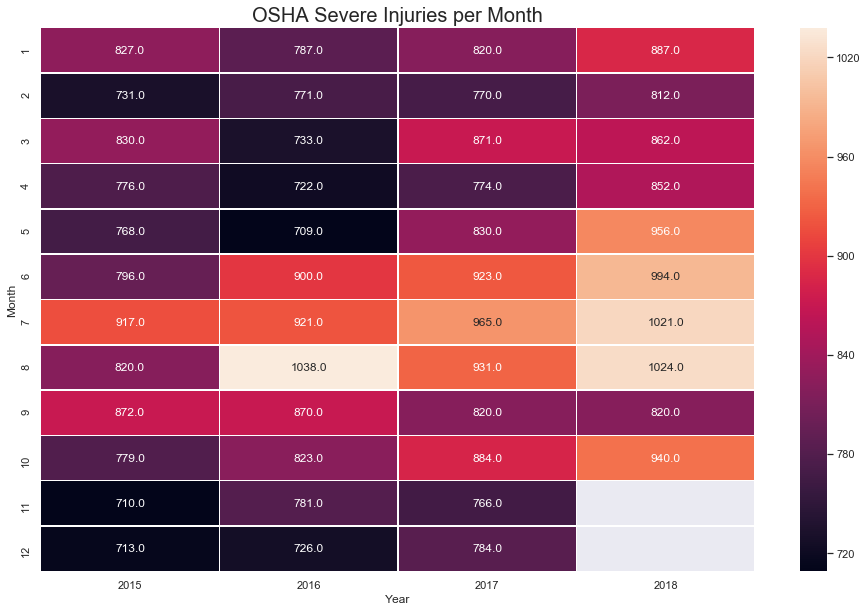

In [52]:
import seaborn as sns
sns.set()
injuries_long = df4
injuries = injuries_long.pivot('Month','Year','Counts')
plt.figure(figsize=(16,10))
plt.title('OSHA Severe Injuries per Month', fontsize =20)
sns.heatmap(injuries, annot=True, fmt = '.1f',linewidths = .5)
